In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
# df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# # Build main features day by day, showing a progress bar
# frames = []
# print("Generating main features…")
# for day, day_df in tqdm(
#     df_sign.groupby(df_sign.index.normalize()),
#     desc="Days", unit="day"
# ):
#     # day_df has only that session’s bars
#     feats_main = feats.features_creation(df=day_df) # base_window for indicators calculation set by defauls as the smooth_sign_win
#     frames.append(feats_main)

# # Concatenate per-day feature frames back into one DataFrame
# df_feat_main = pd.concat(frames).sort_index()


df_sign = pd.read_csv(
    params.sign_csv, index_col=0, parse_dates=True
)

frames = []
print("Generating all indicators features (standard, engineered, custom) …")
for day, day_df in tqdm(
    df_sign.groupby(df_sign.index.normalize()),
    desc="Days", unit="day"
):
    # 1) Standard textbook indicators
    std_feats = feats.create_standard_features(day_df)

    # 2) Engineered signals _directly_ on standard indicators
    eng_feats = feats.features_engineering(
        std_feats
    )

    # 3) Custom-window indicators aligned to smooth_sign_win_tick
    cust_feats = feats.create_custom_window_features(
        day_df,
        base_w=params.smooth_sign_win_tick
    )

    # 4) Merge all three sets and drop any rows with NaNs
    feats_main = pd.concat([std_feats, eng_feats, cust_feats], axis=1).dropna()
    frames.append(feats_main)

# Final concatenation across days
df_feat = pd.concat(frames).sort_index()
df_feat

Generating all indicators features (standard, engineered, custom) …


Days:   0%|          | 0/5400 [00:00<?, ?day/s]

,open,high,low,close,volume,bid,ask,signal,rsi,macd_line,macd_signal,macd_diff,sma_20,sma_100,atr,bb_lband,bb_hband,bb_width,plus_di,minus_di,adx,obv,obv_sma,vwap,vol_spike,hour,day_of_week,month,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,cust_ema_7,cust_sma_7,cust_sma_15,cust_sma_30,cust_macd_diff,cust_atr_15,cust_atr_30,cust_bb_lband_15,cust_bb_hband_15,cust_bb_width_15,cust_rsi_15,cust_stoch_k_15,cust_stoch_d_3,cust_plus_di_15,cust_minus_di_15,cust_adx_15,cust_obv,cust_obv_sma_15,cust_vwap_dev_15,cust_vol_spike_15,cust_r_1,cust_r_15,cust_r_30,cust_vol_15
2004-01-02 13:09:00,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.021536,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,19.934,6791837.50,6789218.750,0.764,1.558,13.0,4.0,1.0,0.000,-0.000,0.00,30.0,0.000,2.618750e+03,0.0,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,18.696,6791837.50,6777137.500,-0.000053,1.567,-0.000022,-0.000066,-0.000066,0.000009
2004-01-02 13:10:00,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.023284,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,25.653,6737062.50,6796437.500,0.764,1.671,13.0,4.0,1.0,0.000,-0.000,0.00,30.0,-5.653,-5.937500e+04,0.0,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,24.117,6737062.50,6785741.667,-0.000066,1.687,-0.000022,-0.000088,-0.000088,0.000010
2004-01-02 13:11:00,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.025175,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,30.964,6675593.75,6797265.625,0.764,1.748,13.0,4.0,1.0,0.000,-0.000,0.00,30.0,-10.964,-1.216719e+05,0.0,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,29.175,6675593.75,6788381.250,-0.000076,1.772,-0.000022,-0.000110,-0.000110,0.000011
2004-01-02 13:12:00,0.764185,0.764185,0.764185,0.764185,68162.50,0.763614,0.764757,0.027222,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,35.895,6607431.25,6791225.000,0.764,1.792,13.0,4.0,1.0,0.000,-0.000,0.00,30.0,-15.895,-1.837938e+05,0.0,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,33.897,6607431.25,6784610.000,-0.000085,1.824,-0.000022,-0.000131,-0.000131,0.000011
2004-01-02 13:13:00,0.764169,0.764169,0.764169,0.764169,74856.25,0.763597,0.764740,0.029436,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,40.474,6532575.00,6777837.500,0.764,1.809,13.0,4.0,1.0,0.000,-0.000,0.00,30.0,-20.474,-2.452625e+05,0.0,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,38.304,6532575.00,6773981.667,-0.000091,1.849,-0.000022,-0.000153,-0.000153,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.684908,67.217,0.176,0.135,0.041,196.326,195.931,0.251,195.927,196.725,0.004,36.312,7.485,30.194,4282659.00,3253867.571,196.468,1.641,20.0,2.0,6.0,0.395,0.041,0.09,0.0,10.194,1.028791e+06,3.0,196.567,196.547,196.366,196.181,0.020,0.247,0.219,195.940,196.792,0.004,66.709,73.661,62.549,35.895,7.958,28.287,4282659.00,3226657.000,0.001545,1.703,0.000635,0.003639,0.004048,0.000804
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.612206,61.669,0.179,0.144,0.036,196.349,195.937,0.260,195.925,196.772,0.004,34.721,6.704,32.868,3822029.00,3316982.500,196.503,1.763,20.0,2.0,6.0,0.412,0.036,0.00,0.0,12.868,5.050465e+05,3.1,196.594,196.557,196.406,196.210,0.007,0.256,0.225,195.986,196.827,0.004,61.512,58.962,65.041,34.426,7.170,30.770,3822029.00,3291745.000,0.000636,1.842,-0.000712,0.0

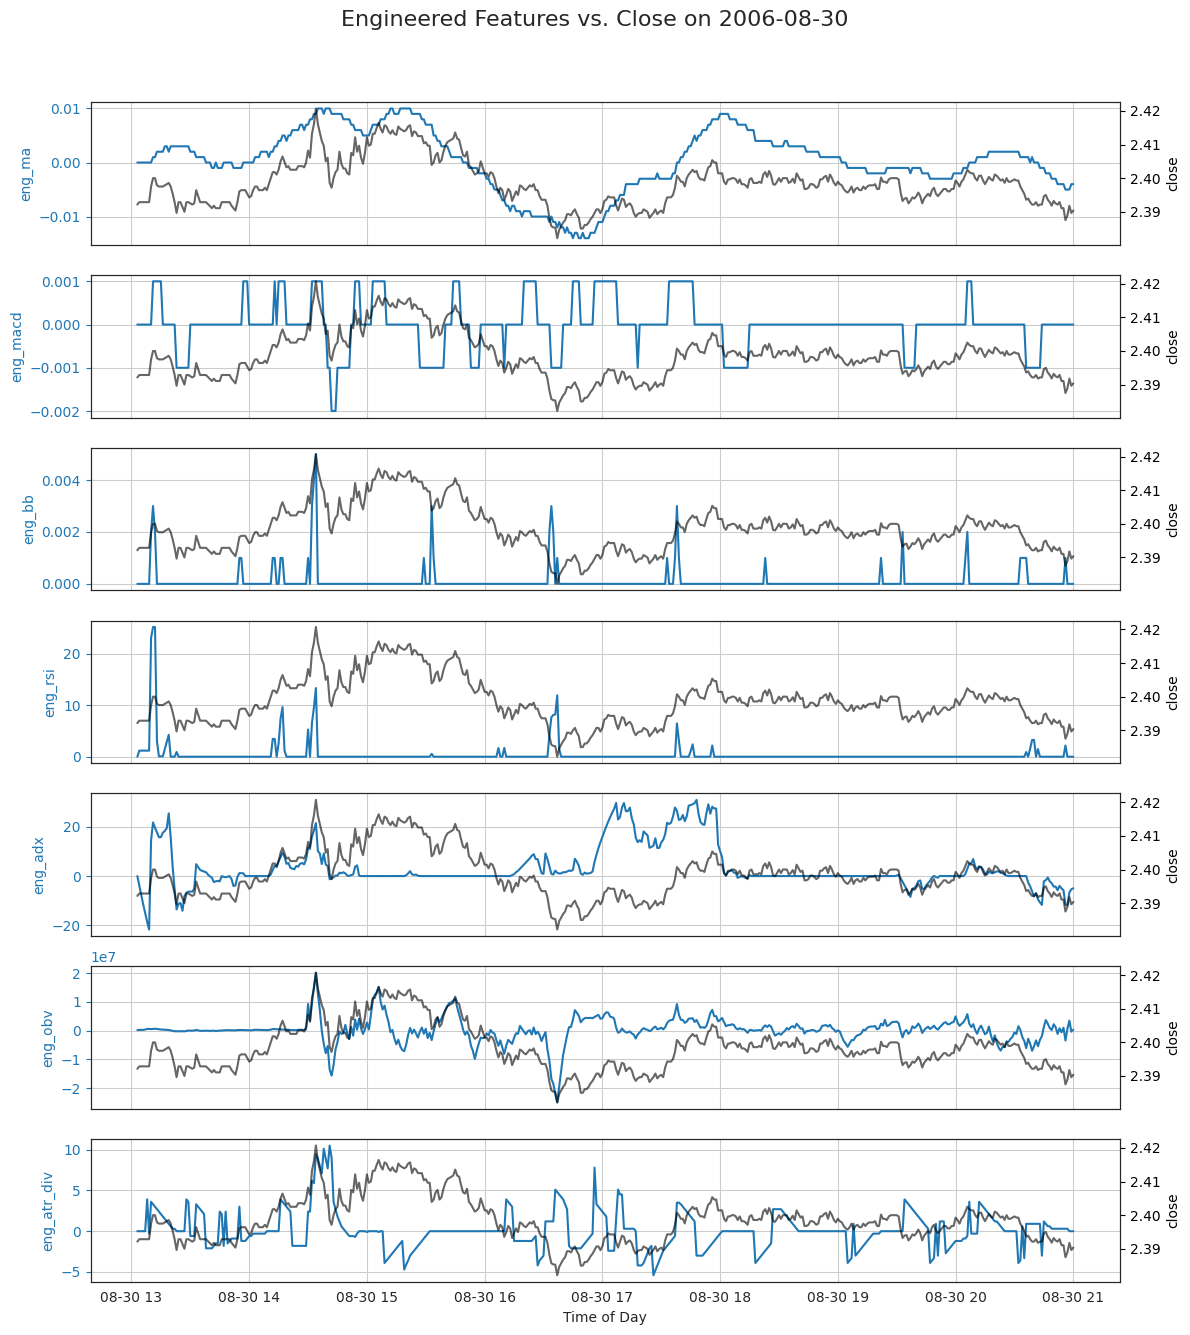

In [4]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat.index.normalize() == random_day
df_day_feats = df_feat.loc[mask, eng_features]
df_day_close = df_feat.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


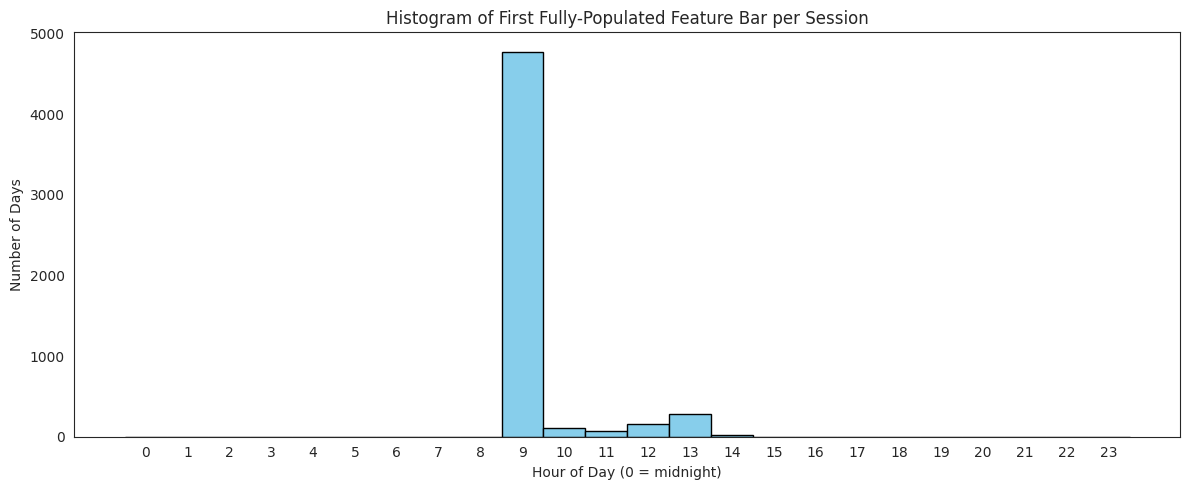

In [5]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before the model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [6]:
importlib.reload(feats) ###################

# Scaling all features indicators

df_feat_all = feats.scale_with_splits(
    df           = df_feat,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

df_feat_all

Scaling splits:   0%|          | 0/3 [00:00<?, ?split/s]

train days:   0%|          | 0/3833 [00:00<?, ?day/s]

val days:   0%|          | 0/785 [00:00<?, ?day/s]

test days:   0%|          | 0/784 [00:00<?, ?day/s]

,open,high,low,close,volume,obv,obv_sma,vwap,bb_width,vol_spike,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,cust_vwap_dev_15,cust_vol_spike_15,macd_line,macd_signal,macd_diff,sma_20,sma_100,bid,ask,signal,rsi,atr,bb_lband,bb_hband,plus_di,minus_di,adx,hour,day_of_week,month,cust_ema_7,cust_sma_7,cust_sma_15,cust_sma_30,cust_macd_diff,cust_atr_15,cust_atr_30,cust_bb_lband_15,cust_bb_hband_15,cust_bb_width_15,cust_rsi_15,cust_stoch_k_15,cust_stoch_d_3,cust_plus_di_15,cust_minus_di_15,cust_adx_15,cust_obv,cust_obv_sma_15,cust_r_1,cust_r_15,cust_r_30,cust_vol_15
2004-01-02 13:09:00,0.000123,0.000117,0.000136,0.000136,0.000296,0.322382,0.322619,0.000087,0.000000,0.661611,0.498249,0.500632,0.0,1.0,0.497414,0.492115,0.499921,0.493266,0.662082,0.509338,0.467641,0.484536,0.000087,0.000052,0.763664,0.764807,0.021536,0.000,0.000,0.764,0.764,0.000,100.000,19.934,0.496,-0.976,0.696,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,18.696,6791837.50,6777137.500,-0.000022,-0.000066,-0.000066,0.000009
2004-01-02 13:10:00,0.000123,0.000117,0.000135,0.000135,0.000338,0.322367,0.322621,0.000087,0.000000,0.681923,0.498249,0.500632,0.0,1.0,0.459685,0.489207,0.499921,0.491771,0.683168,0.509338,0.467641,0.484536,0.000087,0.000052,0.763647,0.764790,0.023284,0.000,0.000,0.764,0.764,0.000,100.000,25.653,0.496,-0.976,0.696,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,24.117,6737062.50,6785741.667,-0.000022,-0.000088,-0.000088,0.000010
2004-01-02 13:11:00,0.000123,0.000116,0.000135,0.000135,0.000379,0.322351,0.322621,0.000087,0.000000,0.694873,0.498249,0.500632,0.0,1.0,0.423949,0.486280,0.499921,0.490621,0.697066,0.509338,0.467641,0.484536,0.000087,0.000052,0.763631,0.764773,0.025175,0.000,0.000,0.764,0.764,0.000,100.000,30.964,0.496,-0.976,0.696,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,29.175,6675593.75,6788381.250,-0.000022,-0.000110,-0.000110,0.000011
2004-01-02 13:12:00,0.000122,0.000116,0.000135,0.000135,0.000421,0.322334,0.322619,0.000087,0.000000,0.701975,0.498249,0.500632,0.0,1.0,0.390647,0.483361,0.499921,0.489585,0.705182,0.509338,0.467641,0.484536,0.000087,0.000052,0.763614,0.764757,0.027222,0.000,0.000,0.764,0.764,0.000,100.000,35.895,0.496,-0.976,0.696,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,33.897,6607431.25,6784610.000,-0.000022,-0.000131,-0.000131,0.000011
2004-01-02 13:13:00,0.000122,0.000116,0.000135,0.000134,0.000462,0.322314,0.322616,0.000087,0.000000,0.704663,0.498249,0.500632,0.0,1.0,0.359649,0.480471,0.499921,0.488895,0.708985,0.509338,0.467641,0.484536,0.000087,0.000052,0.763597,0.764740,0.029436,0.000,0.000,0.764,0.764,0.000,100.000,40.474,0.496,-0.976,0.696,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,38.304,6532575.00,6773981.667,-0.000022,-0.000153,-0.000153,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,3.402747,3.403966,3.403918,3.405149,0.002393,0.321726,0.321693,3.402274,0.534921,0.676688,1.000000,1.000000,1.0,0.0,0.563850,0.539505,0.744222,0.677518,0.685846,0.808149,0.749478,0.625430,3.399805,3.398280,196.667400,196.962600,0.684908,67.217,0.251,195.927,196.725,36.312,7.485,30.194,-0.948,0.033,-0.250,196.567,196.547,196.366,196.181,0.020,0.247,0.219,195.940,196.792,0.004,66.709,73.661,62.549,35.895,7.958,28.287,4282659.00,3226657.000,0.000635,0.003639,0.004048,0.000804
2025-06-18 20:57:00,3.405004,3.405355,3.402701,3.402717,0.002858,0.321606,0.321710,3.402882,0.534921,0.697317,1.000000,1.000000,0.0,0.0,0.581151,0.515330,0.751964,0.572606,0.707927,0.813243,0.768267,0.608247,3.400205,3.398384,196.527500,196.822500,0.612206,61.669,0.260,195.925,196.772,3

In [ ]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)

In [ ]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
print("saved df")